# Cleaning notebook

- I. First filtering of interest : only product with name and sold in France

- II. Missing values : first thresholds

- III. Aberrant value handling

- IV. Atypical values handling : interquartile range : binning variable


In [83]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import missingno as msno
from sklearn.linear_model import LinearRegression
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import csv 

In [84]:
data = pd.read_csv('fr.openfoodfacts.org.products.csv',sep='\t', low_memory=False)

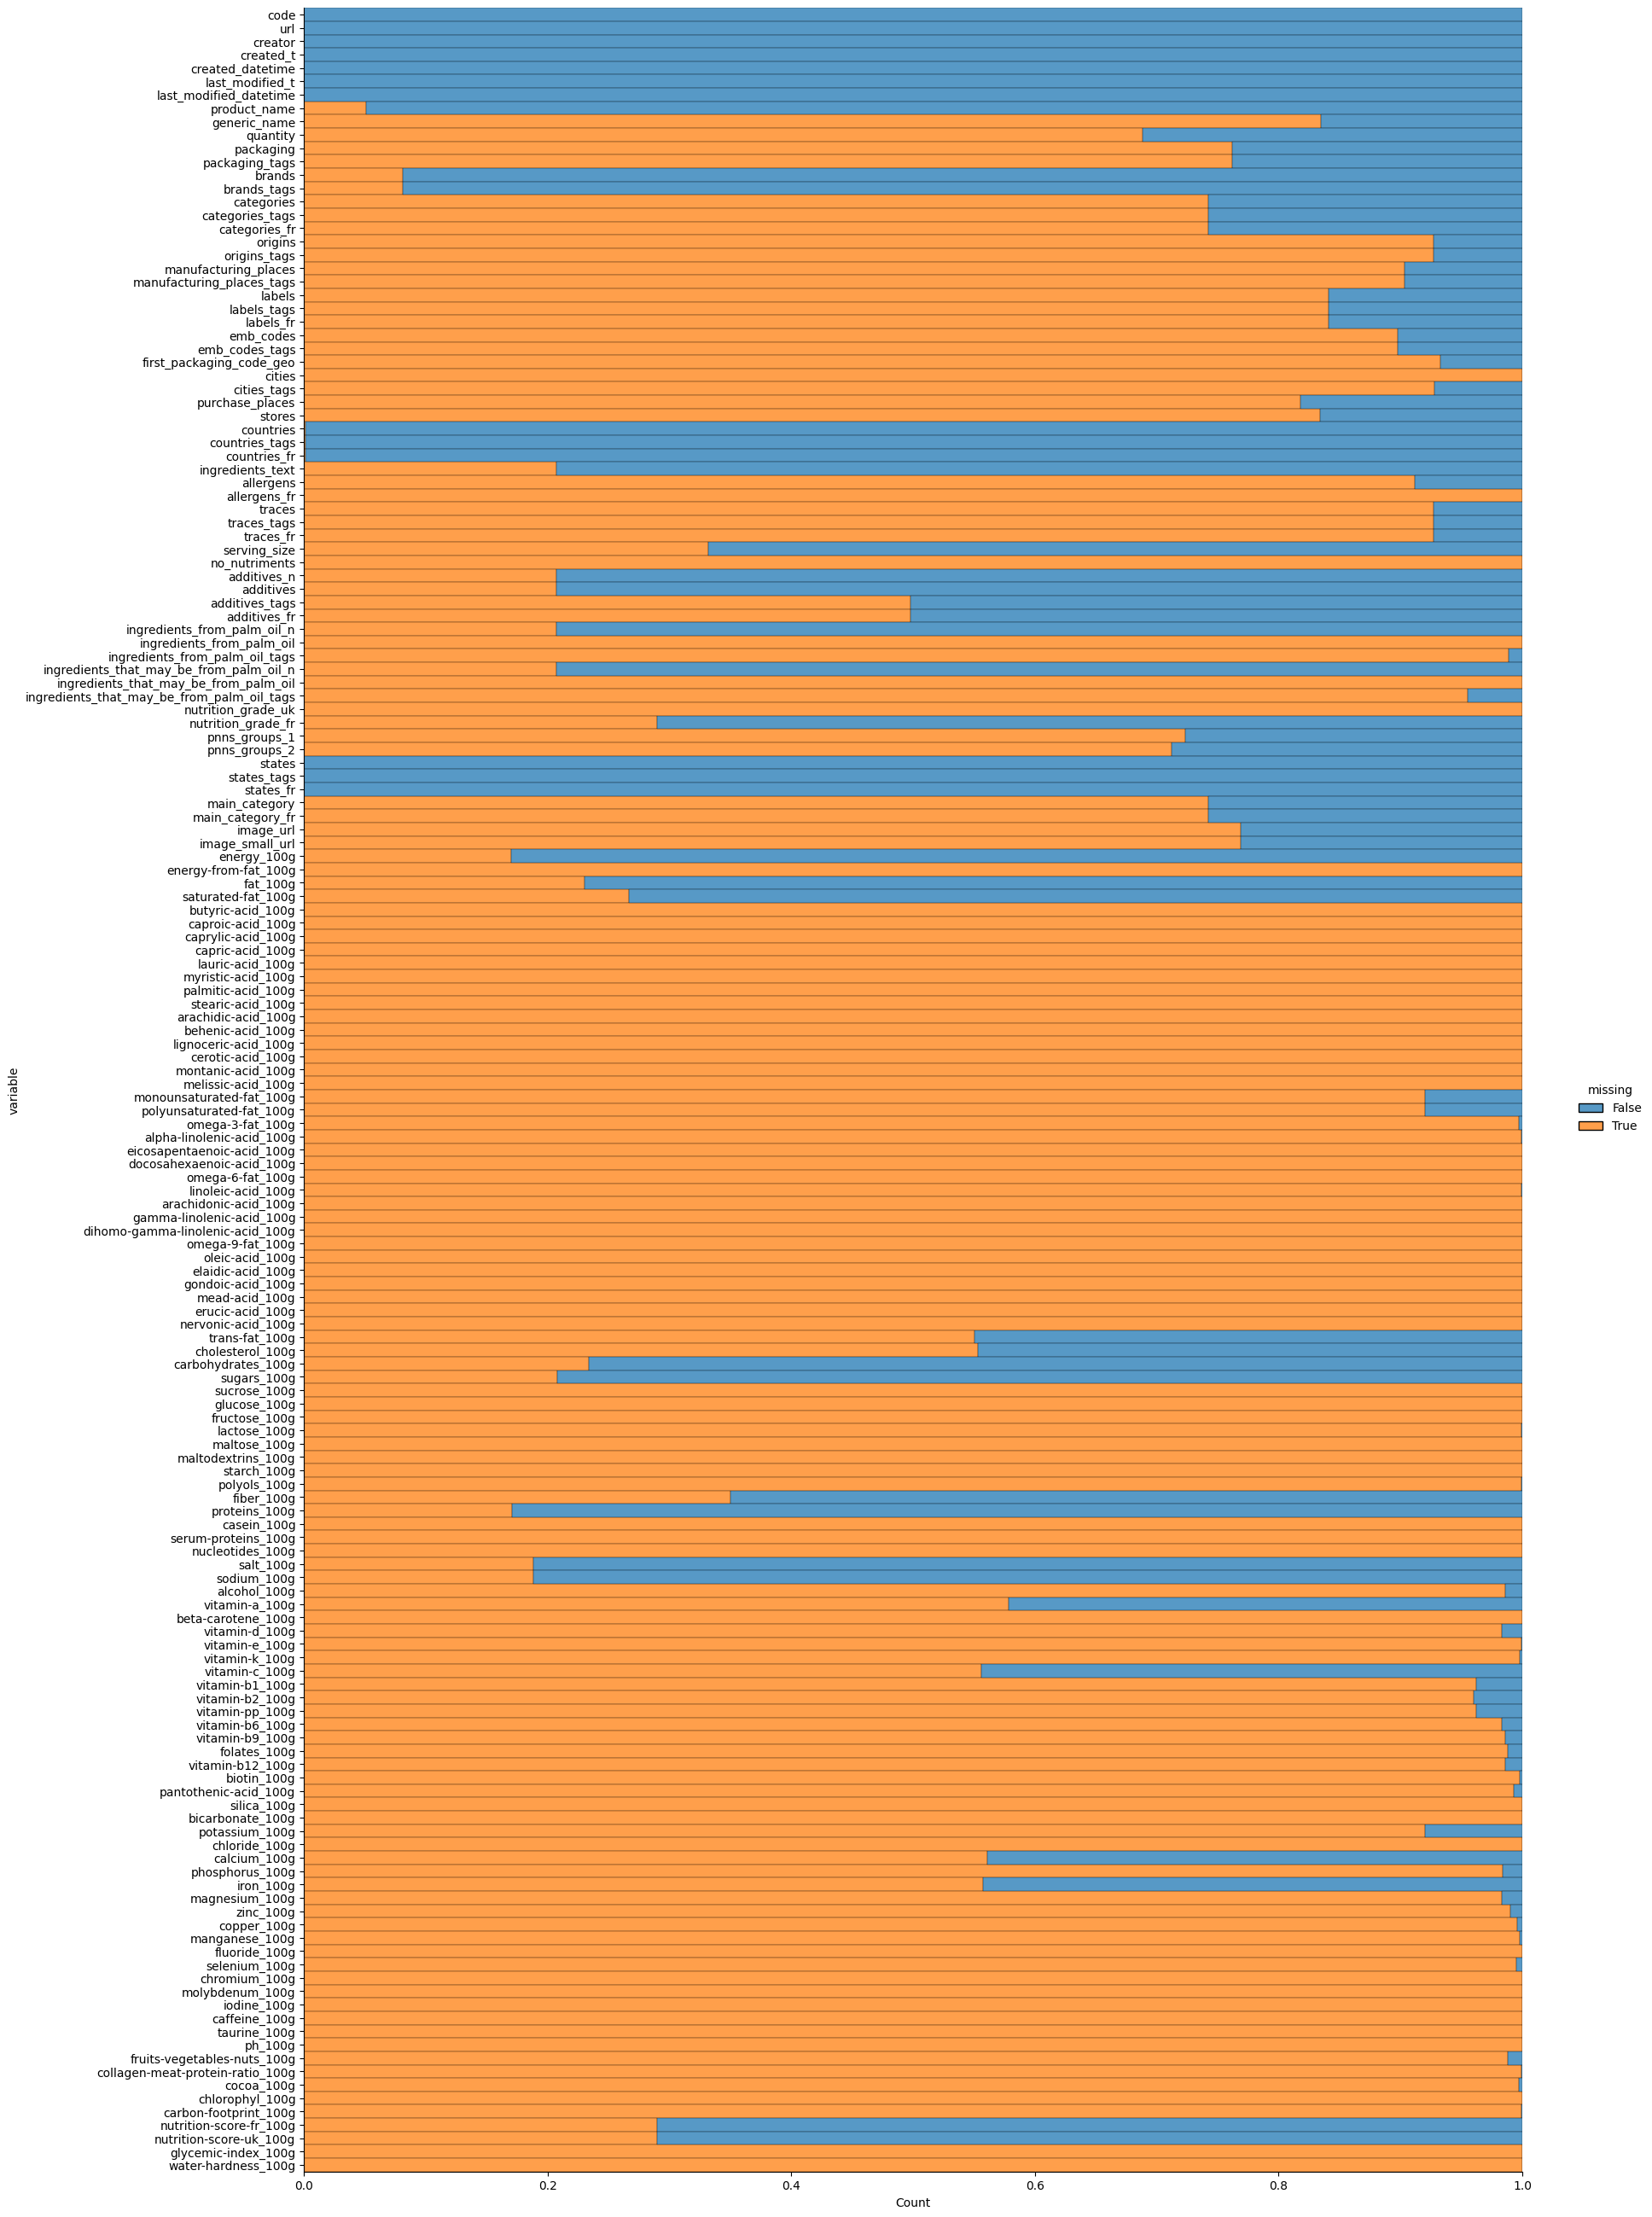

In [85]:
subdata = data.sample(n=1000,axis='rows')
sns.displot(
    data=subdata.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=3.25
)
plt.gcf().set_size_inches(20, 30)


## For the application we are interested in the following variables :

-  countries, countries_tag , countries_fr : *qualitative variable* 
-  product name : *qualitative variable*
-  salt_100g and sodium_100g : *continuous quantitative* variables
-  sugars_100g, fiber_100g and carbohydrates_100g : *continuous quantitative* variable
-  nutrition_grade_fr : **qualitative ordinal variable**
-  nutrition-score-fr_100g nutrition-score-uk_100g : *continuous quantitative variable*
-  fat_100g saturated-fat_100g *continuous quantitative* variable
-  additives_n : *continuous quantitative* variable
-  calcium_100g, iron_100g and cholesterol_100g : *continuous quantitative variable*

### We will drop the following values that are not in the interest of our study : 
**code, creator, created_t, created_datetime, last_modified_t, last_modified_datetime**
and **ingredients_from_palm_oil_n** and **ingredients_that_may_be_from_palm_oil_n** as there are no proven link between palm oil and heart diseases. 
brands and brands_tags, serving_size, 

In [86]:
cleaned_data = data.drop(columns=['url','code','creator','created_t','created_datetime','states_tags','states_fr','states'\
    ,'last_modified_t','last_modified_datetime','ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil_n',\
        'serving_size','brands','brands_tags','additives','ingredients_text','nutrition-score-uk_100g','quantity','packaging',
    'packaging_tags', 'categories','categories_tags','categories_fr','pnns_groups_1','pnns_groups_2', 'main_category',
    'main_category_fr','image_url','image_small_url'])

## First filtering of interest : only product with name and sold in France
### variable : product name
This variable  will be displayed in the newsletter.

Handling of missing values : product without name should be dropped as there can not be recommended. 

In [87]:
cleaned_data = cleaned_data[cleaned_data['product_name'].notna()]


###   variables : countries, countries_tag , countries_fr  
There are all redundant information but relevant for the application as the product must be available in France.

Therefore the dataset must only contain product sold in France. This variable can be drop afterwards. 


In [88]:
# Drop individuals that does not contain where the product is sold
cleaned_data = cleaned_data[~(cleaned_data['countries_fr'].isna())]

# Filter product sold in France
mask = cleaned_data['countries_fr'].str.contains("France")
cleaned_data.loc[mask,'countries_fr'] = 'France'
cleaned_data = cleaned_data[cleaned_data['countries_fr'] == 'France']

# countries, countries_tags and countries_fr not useful anymore and can be dropped
cleaned_data.drop(columns=['countries', 'countries_tags',  'countries_fr' ],inplace=True)

# Missing values : first thresholds
We choose to remove **variables** that have **more than 50% missing values** (NaN), except specific values that are of interest in out study.

We remove **rows** that have **more than 80% empty values** and we remove identical duplicates.

Further missing values handling is done considering each variable of interest separately

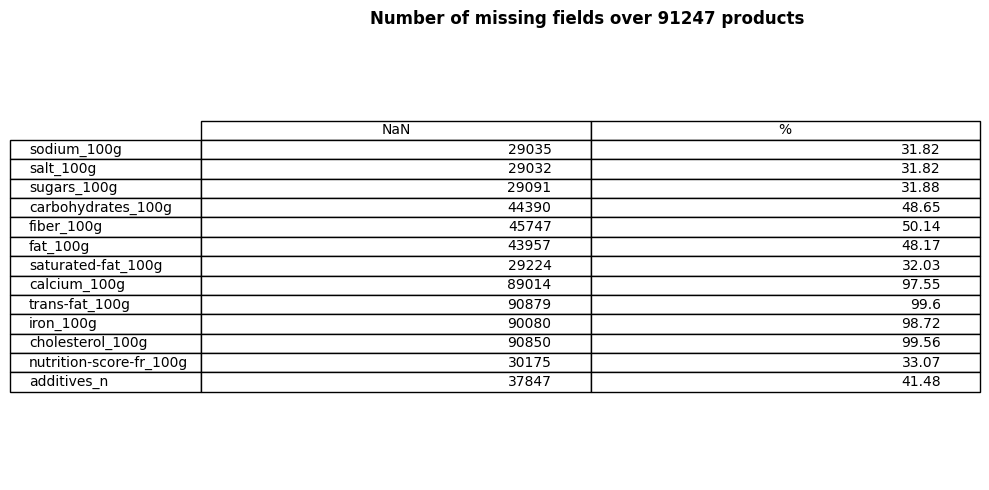

In [89]:
others = ["calcium_100g","trans-fat_100g","iron_100g","cholesterol_100g","nutrition-score-fr_100g","additives_n"]
variables = ["sodium_100g","salt_100g","sugars_100g","carbohydrates_100g","fiber_100g","fat_100g","saturated-fat_100g"]  + others

def plotAbOrMiss(variables):
    OutOfRange = []
    for var in variables:
        OutOfRange.append(  [   cleaned_data[str(var)].isna().sum()  , round( (cleaned_data[str(var)].isna().sum() / cleaned_data.shape[0] )*100   , 2 ) ] )

    fig, ax = plt.subplots() 
    ax.set_axis_off() 
    plt.rcParams["figure.figsize"] = [7.00, 3.50]
    plt.rcParams["figure.autolayout"] = True
    table = ax.table( cellText = OutOfRange,  rowLabels = variables,  colLabels = ["NaN","%"],loc='center')         
    
    ax.set_title("Number of missing fields over " + str(cleaned_data.shape[0]) + " products ", 
                fontweight ="bold") 
    
    plt.show()
    
plotAbOrMiss(variables)

Here, we notice than some variables of interest will not pass our variable threshold.

Therefore,  we save them in temporary Series and add them after the threshold conservation. 

## First missing value handling method : dropping 
Indeed, if a value is not a key variable in our application and do not convey enough information we are dropping the variable. 

In [90]:
print("Data dimension before NaN threshold : " ,cleaned_data.shape)

tmp_calcium            = cleaned_data["calcium_100g"]
tmp_trans_fat          = cleaned_data["trans-fat_100g"]
tmp_iron               = cleaned_data["iron_100g"]
tmp_cholesterol        = cleaned_data["cholesterol_100g"]
tmp_fiber              = cleaned_data["fiber_100g"]

# drop variables that have more than 50% missing values

cleaned_data.dropna(thresh=int(cleaned_data.shape[0] * 0.5),axis=1,inplace=True)

cleaned_data["calcium_100g"]        = tmp_calcium
cleaned_data["trans-fat_100g"]      = tmp_trans_fat
cleaned_data["iron_100g"]           = tmp_iron
cleaned_data["cholesterol_100g"]    = tmp_cholesterol
cleaned_data["fiber_100g"]          = tmp_fiber

# # drop product that have more than 80% missing values
cleaned_data.dropna(thresh=int(cleaned_data.shape[1]*0.8),axis=0,inplace=True)

# #drop duplicates
cleaned_data.drop_duplicates(inplace=True)
print("Data dimension after NaN threshold: ", cleaned_data.shape)


Data dimension before NaN threshold :  (91247, 129)
Data dimension after NaN threshold:  (25587, 17)


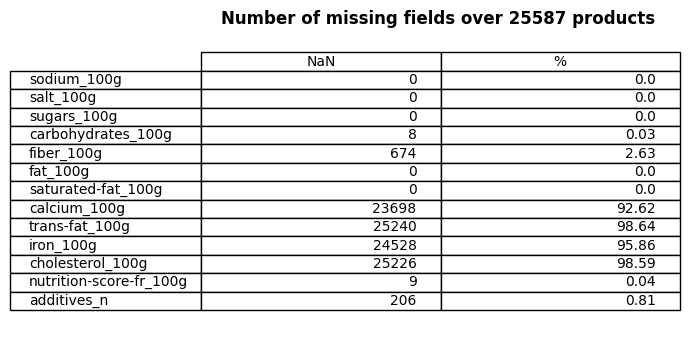

In [91]:
plotAbOrMiss(variables)

We dropped products with very low information. As expected, it decrease the number of NaN fields for all variable. 

## Second and third method : Imputation by the median value or null value

A lot of products have no information about specific molecules.
We know that most food materials contain these molecules but is low quantity. 

From the data distribution below, we notice that the mean and median can be very different for these molecules. 

The mean is more impacted by outliers that is why we use **imputation by the median value**. 

We know that a lot of food material do not have fiber, therefore we do a **imputation by a constant, here 0**. 


In [92]:
cleaned_data[others].describe()

,calcium_100g,trans-fat_100g,iron_100g,cholesterol_100g,nutrition-score-fr_100g,additives_n
count,1889.000000,347.000000,1059.000000,361.000000,25578.000000,25381.000000
mean,0.319292,0.159176,0.046131,0.042577,6.540113,1.944880
std,1.822316,0.469985,0.797526,0.574140,8.918460,2.523646
min,0.000000,0.000000,0.000000,0.000000,-15.000000,0.000000
25%,0.120000,0.000000,0.002475,0.000000,0.000000,0.000000
50%,0.130000,0.000000,0.005300,0.000000,5.000000,1.000000
75%,0.343000,0.125000,0.008000,0.002500,14.000000,3.000000
max,69.500000,7.140000,25.000000,10.900000,35.000000,21.000000


In [93]:
# save specific variables of interest (even though it is below threshold for later study )
print("Calcium      median : ",  cleaned_data['calcium_100g'].median())
print("Trans-fat    median : ",  cleaned_data["trans-fat_100g"].median())
print("Iron         median : ",  cleaned_data["iron_100g"].median())
print("Cholesterol  median : ",  cleaned_data["cholesterol_100g"].median())
print("Carbohydrates  median : ",  cleaned_data['carbohydrates_100g'].median())
print("Nutrition-score  median : ",  cleaned_data['nutrition-score-fr_100g'].median())
print("Replace",cleaned_data['additives_n'].isna().sum()," additives_n NaN values by median")

cleaned_data["calcium_100g"].fillna(cleaned_data['calcium_100g'].median(),inplace= True)
cleaned_data["trans-fat_100g"].fillna(cleaned_data["trans-fat_100g"].median(),inplace= True)
cleaned_data["iron_100g"].fillna(cleaned_data["iron_100g"].median(),inplace= True)
cleaned_data["cholesterol_100g"].fillna(cleaned_data["cholesterol_100g"].median(),inplace= True)
cleaned_data['carbohydrates_100g'].fillna(cleaned_data['carbohydrates_100g'].median(),inplace= True)
cleaned_data['nutrition-score-fr_100g'].fillna(cleaned_data['nutrition-score-fr_100g'].median(),inplace=True)
cleaned_data['additives_n'].fillna(cleaned_data['additives_n'].median(),inplace=True)

# If fiber is missing we impute that there is no fiber within the product and replace it by 0 value
cleaned_data["fiber_100g"].fillna(0, inplace= True)

Calcium      median :  0.13
Trans-fat    median :  0.0
Iron         median :  0.0053
Cholesterol  median :  0.0
Carbohydrates  median :  17.6
Nutrition-score  median :  5.0
Replace 206  additives_n NaN values by median


# Aberrant value handling
## Aberrant composition
The sum of **fat, sodium, carbohydrates, proteins** variables that exceed 100 are considered aberrant and are dropped.

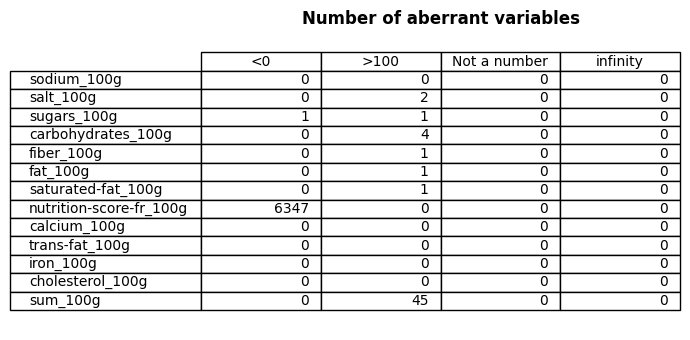

In [94]:
Listof100gVariables = ['fat_100g','sodium_100g','carbohydrates_100g','proteins_100g']

cleaned_data['sum_100g']= cleaned_data[Listof100gVariables].sum(axis=1)

others = ["calcium_100g","trans-fat_100g","iron_100g","cholesterol_100g"]
sums = ["sum_100g"]
var = ["sodium_100g","salt_100g","sugars_100g","carbohydrates_100g","fiber_100g","fat_100g","saturated-fat_100g",'nutrition-score-fr_100g'] 
vars =  var + others + sums
def plotAbOrMiss(variables):
    OutOfRange = []
    for var in variables:
        OutOfRange.append([len(cleaned_data[cleaned_data[str(var)] < 0 ]),len(cleaned_data[cleaned_data[str(var)] > 100 ]),\
            len(cleaned_data[~cleaned_data[str(var)].apply(np.isreal)]),len(cleaned_data[cleaned_data[str(var)].isin([np.inf, -np.inf])] )])

    fig, ax = plt.subplots() 
    ax.set_axis_off() 
    plt.rcParams["figure.figsize"] = [7.00, 3.50]
    plt.rcParams["figure.autolayout"] = True
    table = ax.table( cellText = OutOfRange,  rowLabels = variables,  colLabels = ["<0",">100","Not a number","infinity"],loc='center')         
    
    ax.set_title('Number of aberrant variables', 
                fontweight ="bold") 
    
    plt.show()
plotAbOrMiss(vars)

Here we are dropping the 45 products with an aberrant sum and then dropping this variable "sum_100g" as is it not needed anymore. 

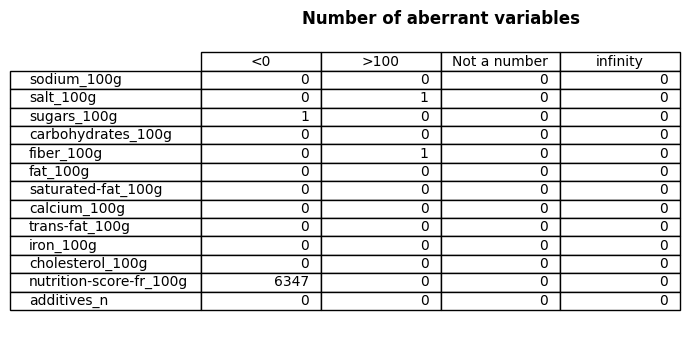

In [95]:
# Drop this values
cleaned_data = cleaned_data[cleaned_data['sum_100g'] <= 100] 

plotAbOrMiss(variables)

cleaned_data.drop(columns=['sum_100g'],inplace=True)


Here, we notice there is still an aberrant fiber value that we will drop. 

We let the nutriscore be below 0 and we will look at it more closely at the end of the cleaning notebook relating it to the nutriscore grade. 

In [96]:
cleaned_data = cleaned_data[cleaned_data["fiber_100g"] <= 100] 

###  Handling aberrant values by **linear regression** : salt and sodium example

As the table above indicates sodium does not content aberrant values but salt does with one value out of range. 

Salt is about 40% sodium and 60% chloride. So there is a linear relation between the two where sodium should be equal to 0.4*salt.

Let's verify that point by a **linear regression**.



In [97]:
pearson_coefficient = st.pearsonr(cleaned_data["sodium_100g"],cleaned_data["salt_100g"])[0]

print("Pearson's  coefficient: " ,round(pearson_coefficient,10))

if pearson_coefficient > 0.99 : 
    print("Positive linear correlation between sodium and salt.")
if pearson_coefficient > 0 : 
    print("Positive correlation between sodium and salt.")
elif pearson_coefficient == 0 :
    print("No correlation between sodium and salt.")
elif ( pearson_coefficient < 0 ) & ( pearson_coefficient > -1 ):
    print("Negative correlation between sodium and salt.")
else : 
    print("Cannot deduce link between two variables")


Pearson's  coefficient:  0.9999999948
Positive linear correlation between sodium and salt.
Positive correlation between sodium and salt.


As Moulin Sel de Guérande is salt, the value of salt should be 100 .

Thanks to the **linear regression** we can compute the corresponding  **sodium** value.

In [98]:
display(cleaned_data[cleaned_data["salt_100g"] > 100 ])

,product_name,additives_n,nutrition_grade_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,calcium_100g,trans-fat_100g,iron_100g,cholesterol_100g,fiber_100g
233372,Sel de Guérande Label Rouge,0.0,c,0.0,0.0,0.0,0.0,0.0,0.0,125.0,49.212598,10.0,0.152,0.0,0.014,0.0,0.0


Sodium value computed by linear regression is  39.37049


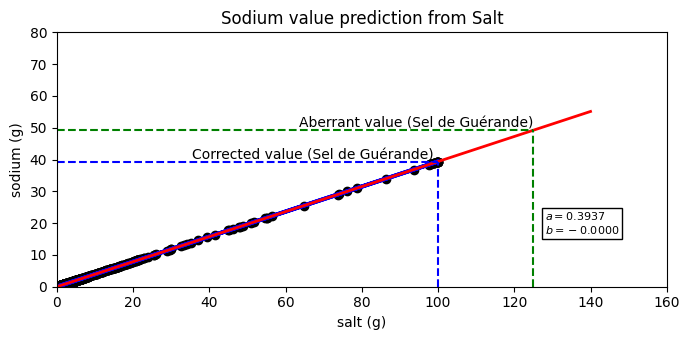

In [99]:

# remove aberrant value for linear regression
regressiondata = cleaned_data[cleaned_data["salt_100g"] <= 100 ]

# input shape must be size X : [n_samples,n_features] , Y : [n_samples, n_targets]
# but our values of sodium are (1,n) and not (1,n), n being the number of values of the dataset
sodium = regressiondata["sodium_100g"].values.reshape(-1,1)
salt = regressiondata["salt_100g"].values.reshape(-1,1)

# Linear regression
reg =  LinearRegression().fit(salt,sodium)

# linear regression coefficient 
b = reg.intercept_[0]
a = reg.coef_[0][0]
legend = '\n'.join((
    r'$a =%.4f$' % (a, ),
    r'$b =%.4f$' % (b, )))

# Plot aberrant values
x = np.linspace(0, 140, 1000)
# First aberrant value
x1 = cleaned_data[cleaned_data["salt_100g"] > 100 ]["salt_100g"].iloc[0]
x2 = 100

saltValue = 100
sodiumValue = reg.predict([[saltValue]])[0][0]
print("Sodium value computed by linear regression is ", round(sodiumValue,5))

offset = 2 
fig, axs = plt.subplots(1, 1)
axs.plot(salt, reg.predict(salt), color='blue', linewidth=3)
axs.plot(x,reg.coef_[0][0]*x + reg.intercept_[0],color='r', linewidth=2)
axs.vlines(x1,0,a*x1 + b ,linestyles ="dashed",color='g')
axs.hlines(y = a*x1 + b,xmin = 0,xmax = x1,linestyles ="dashed",color='g')

axs.vlines(x2,0,a*x2 + b ,linestyles ="dashed",color='b')
axs.hlines(y = a*x2 + b,xmin = 0,xmax = x2,linestyles ="dashed",color='b')

plt.text(x1,  a*x1 +offset, "Aberrant value (Sel de Guérande)", ha='right', va='center')
plt.text(x2,  a*x2 +offset, "Corrected value (Sel de Guérande) ", ha='right', va='center')
plt.text(0.8,0.3,legend,transform=axs.transAxes, fontsize=8,
        verticalalignment='top', bbox=dict(facecolor='none', edgecolor='black', pad=2.0))
axs.set_ylim([0,80])
axs.set_xlim([0,160])
axs.scatter(salt, sodium,  color='black')
axs.set_xlabel("salt (g)")
axs.set_ylabel("sodium (g)")
axs.set_title("Sodium value prediction from Salt")
plt.show()



In [100]:
# correct aberrant value 
cleaned_data.loc[cleaned_data["salt_100g"] > 100 ,["sodium_100g","salt_100g"]] = [[round(sodiumValue,5),saltValue]]

# Atypical values handling : interquartile range : binning variable



###  fat and saturated-fat example : imputation by median from saturated groups

There is no straightforward linear relation between the two variables. 
However, values are still correlate, we will use this correlation to handle atypical values.



Pearson's  coefficient:  0.7467883457


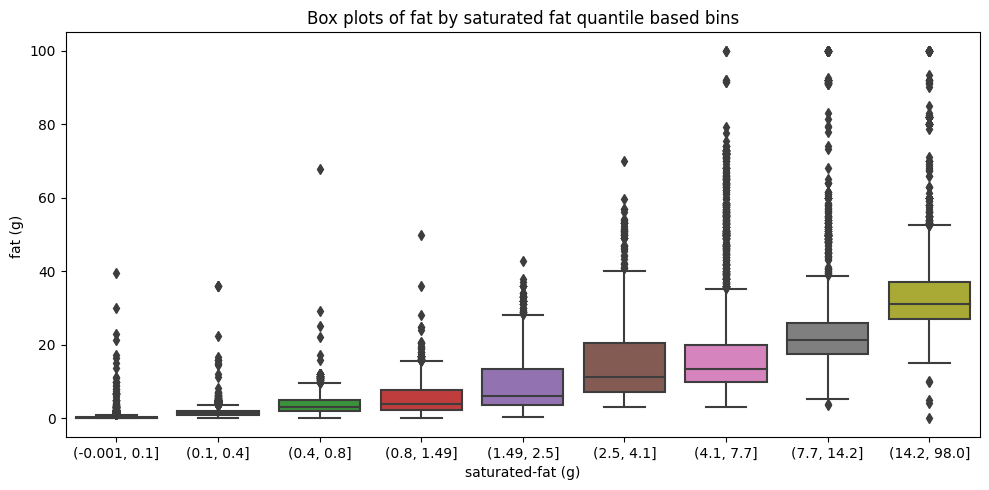

In [101]:
# Person coefficient
pearson_coefficient = st.pearsonr(cleaned_data["fat_100g"],cleaned_data["saturated-fat_100g"])[0]
print("Pearson's  coefficient: " , round(pearson_coefficient,10))

# Quantile binning of fat
plt.rcParams["figure.figsize"] = [10.00, 5.00]
cleaned_data["saturatedFatBins"] = pd.qcut(cleaned_data["saturated-fat_100g"], q=10,duplicates='drop')

def plotFatBins() : 
    boxplot = sns.boxplot(data=cleaned_data, y="fat_100g", x='saturatedFatBins')  
    boxplot.set_xlabel("saturated-fat (g)")
    boxplot.set_ylabel("fat (g) ")
    plt.title("Box plots of fat by saturated fat quantile based bins")
    plt.show()

plotFatBins()

### Binning techniques 
There are two way of binning, the first one is equal interval size bin and the other one is equal population bins. As saturated fat biens is contains most values between 0 and 10g but is in range 0 to 100g we preferred the second method. 
### Handling of outliers
We consider as outliers, values that are higher than **Q3 + 1.5 * IRQ or below Q1 - 1.5 * IRQ for each saturated-fat bin** . 

For each bin, we decided to **replace** fat outlier value **by the median** of the corresponding saturated-fat bin. 

In [102]:

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

# Compute median of saturated-fat_100g for each fat quantiles 
Table = cleaned_data.groupby("saturatedFatBins",as_index=False)["fat_100g"].agg([np.median,  percentile(25), percentile(75)], axis="columns")
Table['interquartile']  = Table['percentile_75'] - Table['percentile_25']
Table['lower_limit'] = Table['percentile_25'] - 1.5*Table['interquartile']
Table['upper_limit'] = Table['percentile_75'] + 1.5*Table['interquartile']
Table.rename(columns={"median": "fat_corresponding_median"},inplace=True)
Table.reset_index(inplace=True)

#replace NaN values with median ones
cleaned_data = cleaned_data.merge(Table)

display(cleaned_data[['product_name',"saturated-fat_100g","saturatedFatBins",'fat_100g',"fat_corresponding_median",'percentile_75','percentile_25',"interquartile",'lower_limit','upper_limit']].sample(n=5))

mask = (cleaned_data['fat_100g'] <= cleaned_data['lower_limit'])  | ( cleaned_data['fat_100g'] >= cleaned_data['upper_limit'] )
cleaned_data["fat_100g"] = np.where(mask,cleaned_data['fat_corresponding_median'],cleaned_data["fat_100g"])

,product_name,saturated-fat_100g,saturatedFatBins,fat_100g,fat_corresponding_median,percentile_75,percentile_25,interquartile,lower_limit,upper_limit
18971,Chocolat noir 70% Pérou Grand cru Piura,25.0,"(14.2, 98.0]",42.0,31.0,37.2,27.0,10.2,11.70,52.50
4693,Cornichons au vinaigre,0.0,"(-0.001, 0.1]",0.0,0.1,0.4,0.0,0.4,-0.60,1.00
10684,Ferme & Fondant Saveur Praliné Façon Rocher (1...,0.6,"(0.4, 0.8]",1.0,3.0,5.0,1.9,3.1,-2.75,9.65
15892,Rillettes de saumon,1.2,"(0.8, 1.49]",19.0,4.0,7.7,2.4,5.3,-5.55,15.65
18465,Fromage Ail & Fines herbes à tartiner,16.0,"(14.2, 98.0]",23.5,31.0,37.2,27.0,10.2,11.70,52.50


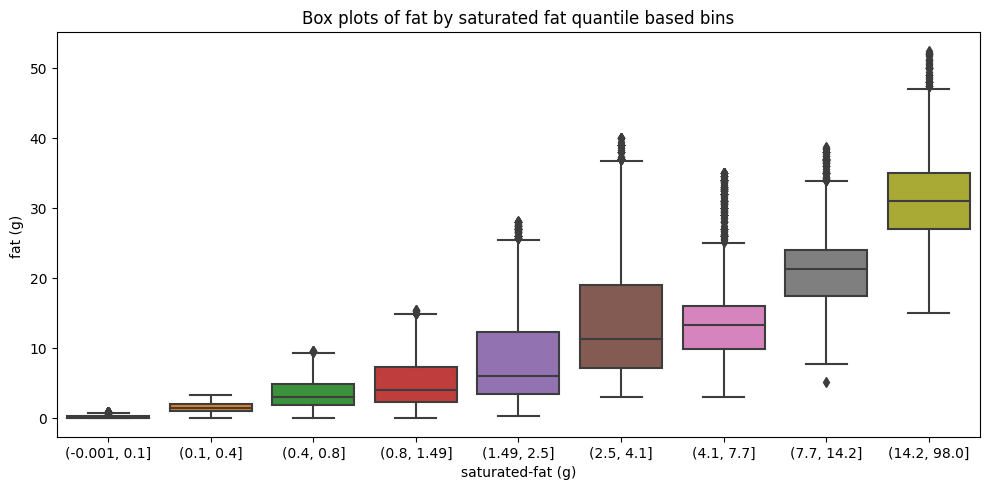

In [103]:
plotFatBins()
#clean up added variables
cleaned_data.drop(columns=["fat_corresponding_median","saturatedFatBins","fat_corresponding_median",'percentile_75','percentile_25',"interquartile",'lower_limit','upper_limit'],inplace=True)

We notice some "new outliers", indeed the interquartile is recalculated.

They were not considered outliers before and we choose to keep these products. 


# Atypical values handling : interquartile range : discrete variable

### nutrition_grade_fr  nutrition-score-fr_100g nutrition-score-uk_100g

From variable definition we have : 

```
nutrition_grade_fr nutrition grade ('a' to 'e'). 

nutrition-score-fr_100g : Nutri-Score - Nutrition score derived from the UK FSA score and adapted for the French market (formula defined by the team of Professor Hercberg)

nutrition-score-uk_100g : nutrition score defined by the UK Food Standards Administration (FSA)

```
We consider as outliers, values that are higher than **Q3 + 1.5 * IRQ or below Q1 - 1.5 * IRQ for each nutrition_grade** .

For each nutrition_grade, we decide to **drop** nutrition-score outliers for each grade. 

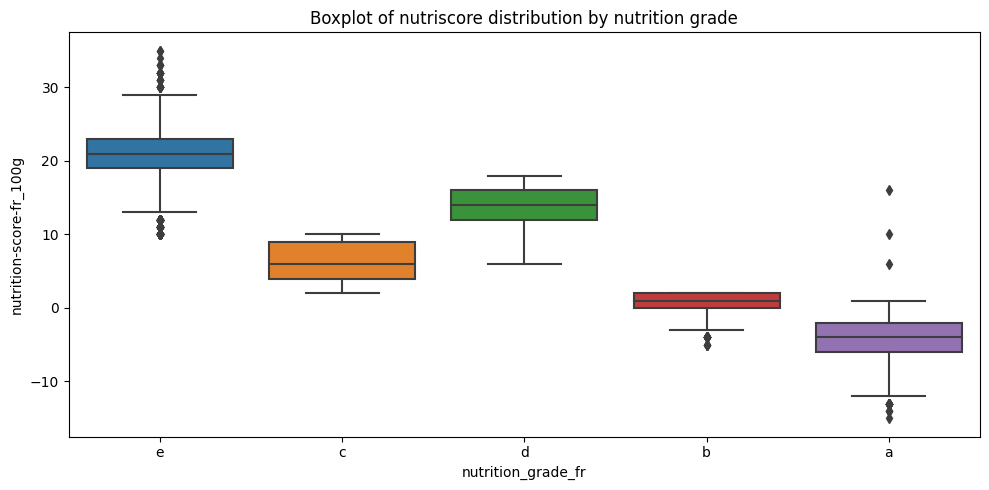

In [104]:
sns.boxplot(data=cleaned_data, y='nutrition-score-fr_100g', x='nutrition_grade_fr') # need to do interquartile cleaning by group + inference of nutriscore from nutriscore fr 
plt.title("Boxplot of nutriscore distribution by nutrition grade")
# Clean up : interquartile upper and lower limit : 
Q1s = cleaned_data.groupby('nutrition_grade_fr')['nutrition-score-fr_100g'].quantile(0.25)
Q3s = cleaned_data.groupby('nutrition_grade_fr')['nutrition-score-fr_100g'].quantile(0.75)
Medians = cleaned_data.groupby('nutrition_grade_fr')['nutrition-score-fr_100g'].quantile(0.5)
IQRs = Q3s - Q1s
Lowers = Q1s - 1.5*IQRs
Uppers = Q3s + 1.5*IQRs

nutriscores = cleaned_data.groupby('nutrition_grade_fr').groups.keys()

for nutriscore in nutriscores : 
    mask =  ( cleaned_data['nutrition_grade_fr'] == nutriscore ) & (( (cleaned_data['nutrition-score-fr_100g'] > Uppers[nutriscore] ) | ( cleaned_data['nutrition-score-fr_100g'] < Lowers[nutriscore] )) )
    cleaned_data.drop(cleaned_data.loc[mask].index, inplace=True)

And then cleaned : 

Text(0.5, 1.0, 'Boxplot of nutriscore distribution by nutrition grade')

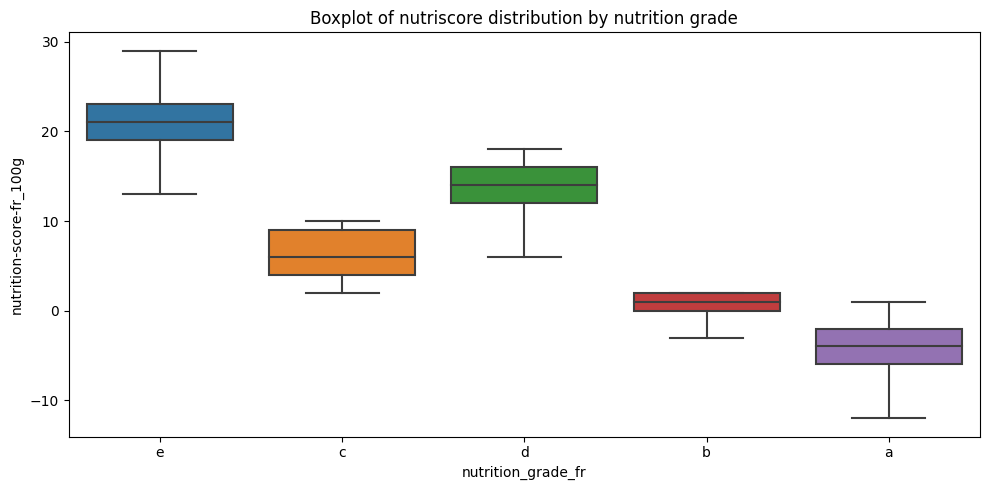

In [105]:
sns.boxplot(data=cleaned_data, y='nutrition-score-fr_100g', x='nutrition_grade_fr') # need to do interquartile cleaning by group + inference of nutriscore from nutriscore fr 
plt.title("Boxplot of nutriscore distribution by nutrition grade")

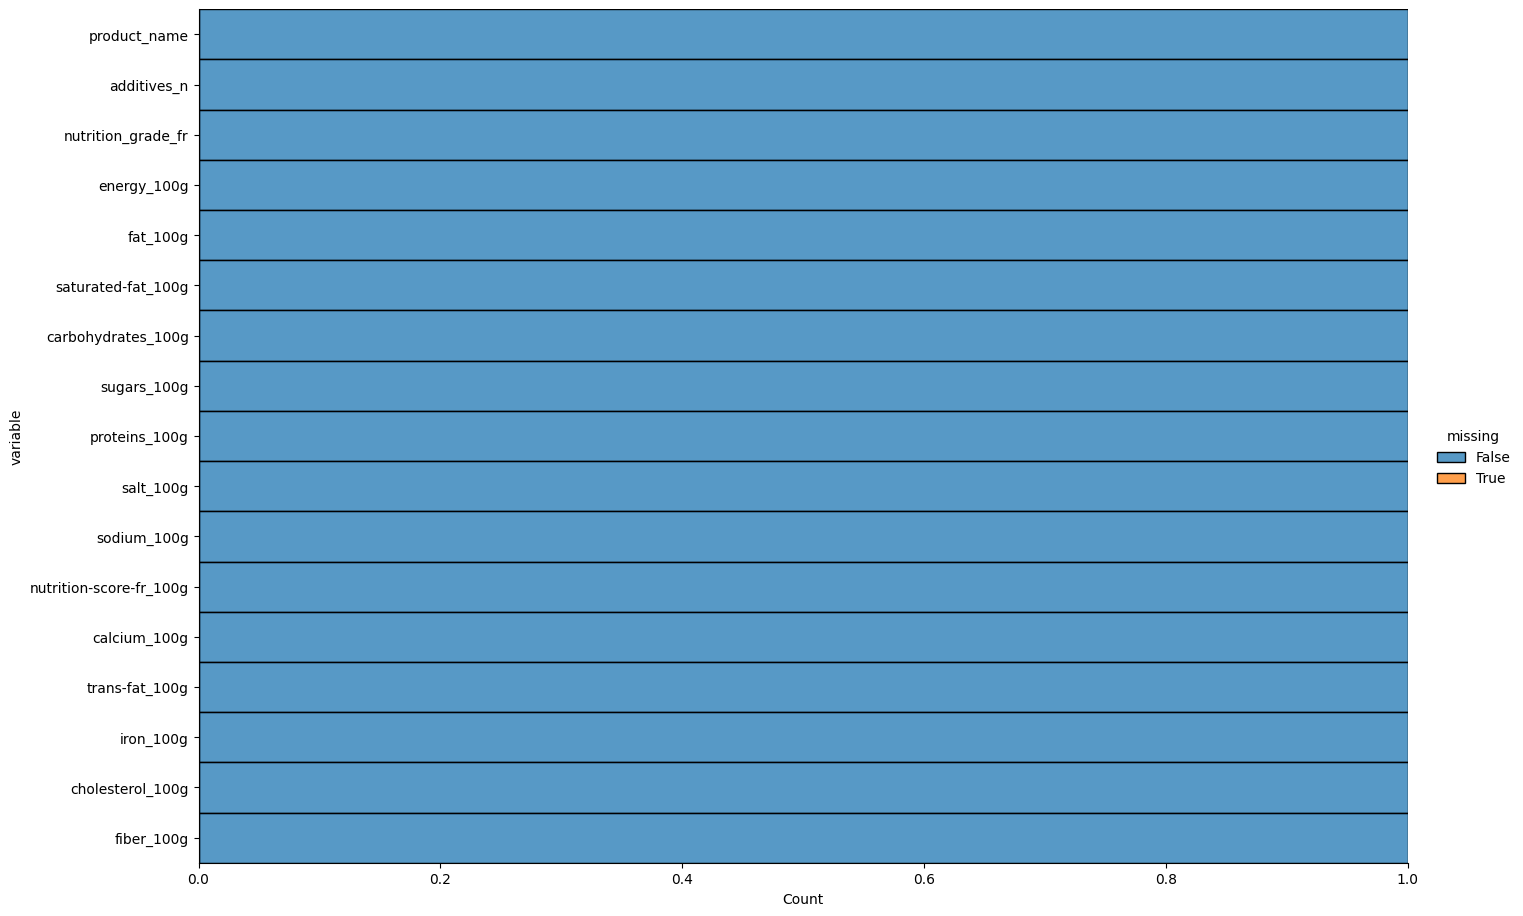

In [106]:

sns.displot(
    data=cleaned_data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=3.25
)
plt.gcf().set_size_inches(15, 10)


In [107]:
cleaned_data.to_csv('clean_data.csv',index=False)